# Utilities

> Utilities function to create a vector grid from raster, reproject raster and many others.

In [1]:
#| default_exp utils

In [1]:
#|export
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import from_origin
import geopandas as gpd
from shapely.geometry import Polygon, box

In [3]:
#|export
def reproject_raster(src_fname:str, # Source raster geotiff file
                     dst_fname:str, # Destination raster geotiff file
                     dst_crs:str='EPSG:4326', # EPSG code to project to
                     ) -> None:
    "Reproject a GeoTiff file to specified crs"
    with rasterio.open(src_fname) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(dst_fname, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)


In [4]:
#|export
def gridder(
    fname_raster:str, # The path to the raster file.
    band:int=1, # The band number to use. Defaults to 1.
    nrows:int=10, # The number of rows in the grid. Defaults to 10.
    ncols:int=10 # The number of columns in the grid. Defaults to 10.
    ) -> gpd.GeoDataFrame: # A GeoDataFrame of the grid cells, with a 'loc_id' column for the cell index.
    "Generate a grid of polygons overlaid on a raster file."
    
    with rasterio.open(fname_raster) as f:
        raster = f.read(band)
        bounds = f.bounds
        crs = f.crs.to_string()

    polygon = box(*bounds)
    gdf_polygon = gpd.GeoDataFrame([1], geometry=[polygon], crs=crs)

    # Calculate the bounds of the polygon
    minx, miny, maxx, maxy = polygon.bounds

    # Calculate the width and height of each cell
    cell_width = (maxx - minx) / ncols
    cell_height = (maxy - miny) / nrows

    # Create an empty list to hold the grid cells
    grid_cells = []

    # Generate the grid
    for i in range(ncols):
        for j in range(nrows):
            # Calculate the coordinates of the cell
            x1 = minx + i * cell_width
            y1 = miny + j * cell_height
            x2 = x1 + cell_width
            y2 = y1 + cell_height

            # Create a box for each cell
            cell = box(x1, y1, x2, y2)
            grid_cells.append(cell)

    # Create a GeoDataFrame from the grid cells
    grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)

    # Intersect the grid with the polygon
    gdf = gpd.overlay(grid, gdf_polygon, how='intersection').reset_index()
    gdf = gdf.drop(0, axis=1)
    return gdf.rename(columns={'index': 'loc_id'})

   loc_id                                           geometry
0       0  POLYGON ((-1.17017 43.02904, -1.17017 42.99324...
1       1  POLYGON ((-1.17017 43.06483, -1.17017 43.02904...
2       2  POLYGON ((-1.17017 43.10063, -1.17017 43.06483...
3       3  POLYGON ((-1.17017 43.13643, -1.17017 43.10063...
4       4  POLYGON ((-1.17017 43.17222, -1.17017 43.13643...


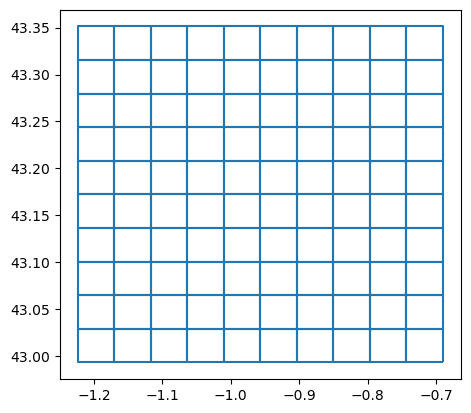

In [5]:
fname_raster = './files/ground-truth-02-4326-simulated.tif'
print(gridder(fname_raster).head())
gridder(fname_raster, nrows=10, ncols=10).boundary.plot();

In [6]:
# import rasterio
# import matplotlib.pyplot as plt
# import geopandas as gpd

# # Load the GeoTIFF file using rasterio
# with rasterio.open(fname_raster) as src:
#     # Read the data from the GeoTIFF file
#     data = src.read(1)
#     # Get the transformation from the GeoTIFF file
#     transform = src.transform
#     # Get the bounds of the dataset
#     bounds = rasterio.transform.array_bounds(data.shape[0], data.shape[1], transform)

# # Load the GeoPandas DataFrame
# gdf = gridder(fname_raster, nrows=10, ncols=10)
# # Create a figure and axis object
# fig, ax = plt.subplots()

# print(bounds)
# # Display the GeoTIFF data as a background image
# # ax.imshow(data, extent=bounds, origin='upper')
# ax.imshow(data)

# # Plot the GeoPandas DataFrame on top of the background image
# gdf.plot(ax=ax, color='red')

In [7]:
#|export
def anonymize_raster(fname_raster:str, # The path to the raster file.
                     new_lon_origin:float, # Longitude of the new origin
                     new_lat_origin:float, # Latitude of the new origin
                     band:int=1, # The band number to use. Defaults to 1.
                     ) -> None:
    "Anonymze a raster by translating it to specified location and values standardized."
    with rasterio.open(src_fname) as src:
        # Calculate the new transform based on the new origin and the same resolution
        new_transform = from_origin(new_lon_origin, new_lat_origin, src.res[0], src.res[1])
        profile = src.profile.copy()
        profile['transform'] = new_transform
        
        # Normalize values
        array = src.read(band)
        normalized_array = (array - array.min()) / (array.max() - array.min())
        
        with rasterio.open(dst_fname, 'w', **profile) as dst:
            dst.write(normalized_array, band)

In [8]:
#| hide
import nbdev; nbdev.nbdev_export()